In [4]:
"""
Note that the PyTorch nn module provides 3D convolutions for volumes or videos.
For now though we'll stick to 2D examples.

(3D convolution is used for operating on CT scan data in Part 2)
"""

import torch.nn as nn

conv = nn.Conv2d(3, 16, kernel_size=3) # 3-channel, 3x3 kernel with 16 out channels
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [5]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [9]:
# Reinit cifar2

import torch
from torchvision import datasets
from torchvision import transforms
data_path = "../data/cifar-10/"


class_names = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck"
]

# Add to dataset transforms
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
    ])
)


transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
    ])
)
   

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [
    (img, label_map[label])
    for img, label in transformed_cifar10
    if label in [0, 2]
]


cifar2_val = [
    (img, label_map[label])
    for img, label in transformed_cifar10_val
    if label in [0, 2]
]

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# Convolution i/o example

img, _ = cifar2[0]
output = conv(img.unsqueeze(0)) # requires dimensions B x C x H x W
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

Bird after convolution:


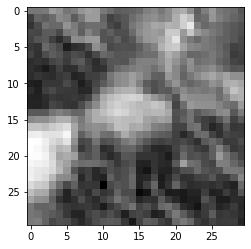

In [11]:
import matplotlib.pyplot as plt

print("Bird after convolution:")

plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

In [12]:
"""
Downsampling is common in multi-layer convolution, to ensure content 
initially larger than our kernels can be captured. This can be done using pooling
or specially strided convolutions. We will focus on maxpooling, which has until now
proved most effective.
"""

pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [13]:
# A convolutional model (basic CNN)

model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # End with fully connected layers
    # Flatten required to transform the 8x8 image up to this point into 512x1 vector
    # We can (and used to have to) forego this by subclassing nn.Module as below,
    # which means abandoning the use of nn.Sequential
    nn.Flatten(),
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

model

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Tanh()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Tanh()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=512, out_features=32, bias=True)
  (8): Tanh()
  (9): Linear(in_features=32, out_features=2, bias=True)
)

In [14]:
# Quick parameter count

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

Alternative approach to Flatten: subclassing nn.Module.

This is also often required for other operations which the provided modules don't supply.

In [15]:
class Net(nn.Module):
    
    """
    The Net class is equivalent to the nn.Sequential model
    we built earlier in terms of submodules; but by writing
    the forward function explicitly, we can manipulate the
    output of self.pool3 directly and call view on it to turn
    it into a B × N vector (see out.view in the forward() function.
    This is now allowed in an nn.Sequential model, for reasons.
    
    https://github.com/pytorch/pytorch/issues/2486
    """
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out
        

In [16]:
# The functional API (torch.nn.functional) provides counterparts for nn.Modules
# which have no internal state (e.g. parameters). This means modules which do not
# require backprop can be placed in the forward() function

import torch.nn.functional as F

class Net(nn.Module):
    
    """
    A version of the prior Net model utilising the Functional API.
    
    It doesn't matter if we don't use it, but it can make the boilerplate
    more concise as below.
    """
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        # tanh as a general-purpose scientific function remains in the torch namespaces
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [17]:
# Does it run?

model = Net()
model(img.unsqueeze(0))

tensor([[ 0.0882, -0.0735]], grad_fn=<AddmmBackward>)

In [18]:
# Training loop definition

import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            
            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print("{} Epoch {}, Training loss {}".format(
                datetime.datetime.now(),
                epoch,
                loss_train / len(train_loader)
            ))

In [19]:
# Dataloader init and run

import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)

2020-12-29 19:45:34.865805 Epoch 1, Training loss 0.555843763860168
2020-12-29 19:45:43.449843 Epoch 10, Training loss 0.3274434448996927
2020-12-29 19:45:53.232652 Epoch 20, Training loss 0.2873439990506051
2020-12-29 19:46:03.063304 Epoch 30, Training loss 0.26469072946317634
2020-12-29 19:46:13.001821 Epoch 40, Training loss 0.24684049421624774
2020-12-29 19:46:22.877061 Epoch 50, Training loss 0.23103074254883324
2020-12-29 19:46:32.682065 Epoch 60, Training loss 0.2194479087925261
2020-12-29 19:46:42.512427 Epoch 70, Training loss 0.20735006466223177
2020-12-29 19:46:52.232926 Epoch 80, Training loss 0.19514886406101997
2020-12-29 19:47:02.207825 Epoch 90, Training loss 0.1824719434378633
2020-12-29 19:47:12.054592 Epoch 100, Training loss 0.1722698227330378


In [20]:
# Measuring accuracy on validation set

val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.89


In [21]:
# Saving and loading the model

torch.save(model.state_dict(), data_path + "birds_vs_airplanes_v1.pt")

In [22]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + "birds_vs_airplanes_v1.pt"))

loaded_model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [23]:
# Training on GPU requires specification of which device you're using,
# And casting the model to it.

# NOTE: CUDA installation was messed up when this was written. TODO: run this on a working
# GPU machine at some point.

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
    
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

Training on device cuda.


In [24]:
train_loader = torch.utils.data.DataLoader(
    cifar2,
    batch_size=64,
    shuffle=True
)

model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2020-12-29 19:47:15.953321 Epoch 1, Training loss 0.5631170367739003
2020-12-29 19:47:19.235770 Epoch 10, Training loss 0.32288539884196726
2020-12-29 19:47:22.803401 Epoch 20, Training loss 0.2858835739694583
2020-12-29 19:47:26.398560 Epoch 30, Training loss 0.25981322675943375
2020-12-29 19:47:30.030267 Epoch 40, Training loss 0.24628958058585027
2020-12-29 19:47:33.625117 Epoch 50, Training loss 0.2291761056348017
2020-12-29 19:47:37.236259 Epoch 60, Training loss 0.2106815562791126
2020-12-29 19:47:40.846859 Epoch 70, Training loss 0.19772793233964095
2020-12-29 19:47:44.453988 Epoch 80, Training loss 0.1800820046596846
2020-12-29 19:47:48.050956 Epoch 90, Training loss 0.1671730545438399
2020-12-29 19:47:51.639351 Epoch 100, Training loss 0.15245778948827915


In [25]:
"""
We have the option of casting a model trained on a certain device to another device
before saving its state dict, but it's more concise (particularly if we're not sure
what kind of device we'll next use it on), if we pass the current device used as map_location
when later loading a saved state_dict.
"""

loaded_model = Net().to(device=device)
loaded_model.load_state_dict(
    torch.load(
        data_path + "birds_vs_airplanes_v1.pt",
        map_location=device # Here
    )
)

<All keys matched successfully>

In [26]:
"""
Changing the width of a NN is easy and can be parameterised as follows.
"""

class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 //2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [27]:
"""
The numbers specifying channels and features for each layer are directly related to
the number of parameters in a model; all other things being equal, they increase the
capacity of the model.

The greater the capacity, the more variability in the inputs the model will be able to
manage; but at the same time, the more likely overfitting will be, since the model can
use a greater number of parameters to memorize unessential aspects of the input.
"""

model = NetWidth()
sum(p.numel() for p in model.parameters())

38386

In [28]:
"""
Training loop with L2 regularization (weight decay)

NOTE: PyTorch's SGD optimizer has a parameter weight_decay which
performs L2 regularization during the model updates.
"""


def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                    datetime.datetime.now(),
                    epoch,
                    loss_train / len(train_loader)
                )
            )

In [29]:
"""
Example network with dropout

NOTE: dropout is normally active during training, while during the evaluation of a
trained model in production, dropout is bypassed or, equivalently, assigned a probability
equal to zero. This is controlled through the train property of the Dropout
module.
"""

class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = slef.conv1_dropout(out)
        out =  F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = NetDropout()
model.train() # Dropout modules active
model.eval() # Dropout modules deactivated

NetDropout(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_dropout): Dropout2d(p=0.4, inplace=False)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_dropout): Dropout2d(p=0.4, inplace=False)
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [30]:
"""
Example network with batch norm

Normalization is still done in eval mode, but the batch norm modules will stop refining
their approximations of mean and stddev, based on inputs to the network, in order to do it.
Instead these are frozen.
"""

class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
        padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = NetBatchNorm()
model.train() # Outputs depend on the statistics of other inputs presented to the model
model.eval() # Normalization parameters are fixed (running estimates of mean and stddev)

NetBatchNorm(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [31]:
"""
Example network with a skip connection
"""

class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
        padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
        kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        # Identity mapping
        # Below, output of the first 2 layers is added to the input of the following 
        # layers, this will encourage larger gradients in these later layers
        # and prevent them from vanishing.
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [32]:
"""
Defining a very deep model dynamically with a for loop
"""

# Create a module subclass which provides the computation for one network block

class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        
        # Bias is perhaps unnecessarily removed, as it would be cancelled out by batch norm
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        
        # Kaiming initialization is used to mirror ResNet paper (by Kaiming He)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x
    

class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        # Define a sequential section of n ResBlocks
        # (notice this is using unpacking within nn.Sequential)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out) # look how elegant 👏👏👏
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

## Chapter exercises

In [33]:
# 1

class ResBlockLargeKernel(nn.Module):
    def __init__(self, n_chans):
        super(ResBlockLargeKernel, self).__init__()
        
        # Bias is perhaps unnecessarily removed, as it would be cancelled out by batch norm
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=5, padding=2, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        
        # Kaiming initialization is used to mirror ResNet paper (by Kaiming He)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x
    

class NetResDeepLargeKernel(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=5, padding=2)
        # Define a sequential section of n ResBlocks
        # (notice this is using unpacking within nn.Sequential)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlockLargeKernel(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out) # look how elegant 👏👏👏
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [36]:
old_model = NetResDeep().to(device)
new_model = NetResDeepLargeKernel().to(device)

print(f"Num parameters of model with 3x3 kernels: {sum(p.numel() for p in old_model.parameters())}")

print(f"Num parameters of model with 5x5 kernels: {sum(p.numel() for p in new_model.parameters())}")

Num parameters of model with 3x3 kernels: 75810
Num parameters of model with 5x5 kernels: 93730


In [37]:
# Train and validate both versions (question b)

# Larger learning rate required due to network depth
optimizer = optim.SGD(old_model.parameters(), lr=3e-3)

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = old_model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2020-12-29 19:49:47.260911 Epoch 1, Training loss 0.4840066734772579
2020-12-29 19:49:55.950919 Epoch 10, Training loss 0.2476724088191986
2020-12-29 19:50:05.584471 Epoch 20, Training loss 0.16053464515194013
2020-12-29 19:50:15.311987 Epoch 30, Training loss 0.10122859655956554
2020-12-29 19:50:25.016132 Epoch 40, Training loss 0.07332556972363193
2020-12-29 19:50:34.763630 Epoch 50, Training loss 0.024704839349101494
2020-12-29 19:50:44.466109 Epoch 60, Training loss 0.015397024164450872
2020-12-29 19:50:54.197031 Epoch 70, Training loss 0.012258114873069772
2020-12-29 19:51:03.942090 Epoch 80, Training loss 0.006410530967798061
2020-12-29 19:51:13.716645 Epoch 90, Training loss 0.004056006446065512
2020-12-29 19:51:23.569216 Epoch 100, Training loss 0.013415566305956169


In [39]:
# Valiation

validate(old_model.cpu(), train_loader, val_loader)

Accuracy train: 0.96
Accuracy val: 0.87


In [40]:
# For new model

optimizer = optim.SGD(new_model.parameters(), lr=3e-3)

# Batch size has to be reduced
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = new_model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2020-12-29 19:53:19.184818 Epoch 1, Training loss 0.48638025875304153
2020-12-29 19:53:28.701418 Epoch 10, Training loss 0.24220475530738284
2020-12-29 19:53:39.250348 Epoch 20, Training loss 0.15255399959482205
2020-12-29 19:53:49.730696 Epoch 30, Training loss 0.06734932794170395
2020-12-29 19:54:00.215141 Epoch 40, Training loss 0.09858652578583758
2020-12-29 19:54:10.735159 Epoch 50, Training loss 0.011422798099814896
2020-12-29 19:54:21.215423 Epoch 60, Training loss 0.004517190350415363
2020-12-29 19:54:31.677924 Epoch 70, Training loss 0.002597382390400051
2020-12-29 19:54:42.119478 Epoch 80, Training loss 0.0018862591634480768
2020-12-29 19:54:52.604809 Epoch 90, Training loss 0.001436693817050831
2020-12-29 19:55:03.095017 Epoch 100, Training loss 0.004036840043256095


In [41]:
validate(new_model.cpu(), train_loader, val_loader)

Accuracy train: 1.00
Accuracy val: 0.89


Bigger kernels have made overfitting worse! Makes sense, as for images of this size, we're probably learning fewer lower level features which generally demark the differences between birds and planes. Instead memorizing more features of the specific images in the training set.

I suspect with a kernel of size 1 x 3, unless we change the stride used, performance will be comparable to a 3 x 3 kernel.

In [42]:
class ResBlockOneByThree(nn.Module):
    def __init__(self, n_chans):
        super(ResBlockOneByThree, self).__init__()
        
        # Bias is perhaps unnecessarily removed, as it would be cancelled out by batch norm
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=(1, 3), padding=(0, 1), bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        
        # Kaiming initialization is used to mirror ResNet paper (by Kaiming He)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x
    

class NetResDeepOneByThree(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=(1, 3), padding=(0, 1))
        # Define a sequential section of n ResBlocks
        # (notice this is using unpacking within nn.Sequential)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlockOneByThree(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out) # look how elegant 👏👏👏
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [43]:
one_by_three_model = NetResDeepOneByThree().to(device)

In [44]:
# Train and eval

optimizer = optim.SGD(one_by_three_model.parameters(), lr=3e-3)

# Batch size has to be reduced
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = one_by_three_model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2020-12-29 19:55:09.861584 Epoch 1, Training loss 0.47905172455083034
2020-12-29 19:55:18.878777 Epoch 10, Training loss 0.2714827323130741
2020-12-29 19:55:28.830213 Epoch 20, Training loss 0.19067425024547394
2020-12-29 19:55:38.771928 Epoch 30, Training loss 0.13264740494548516
2020-12-29 19:55:48.758019 Epoch 40, Training loss 0.06971368054817816
2020-12-29 19:55:58.760046 Epoch 50, Training loss 0.05315287613493812
2020-12-29 19:56:08.727035 Epoch 60, Training loss 0.019715420533991924
2020-12-29 19:56:18.761959 Epoch 70, Training loss 0.01563498870451834
2020-12-29 19:56:28.870933 Epoch 80, Training loss 0.009897100804432941
2020-12-29 19:56:38.923422 Epoch 90, Training loss 0.005938492508109802
2020-12-29 19:56:48.903229 Epoch 100, Training loss 0.004672651847225324


In [45]:
validate(one_by_three_model.cpu(), train_loader, val_loader)

Accuracy train: 1.00
Accuracy val: 0.88


Huh, no great change. Overfitting, overfitting, overfitting.